# Environment

---



## Prepare the data

---



In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarah","key":"KGAT_7cd9ae0d22ee94420d27e9969b472ec7"}\r\n\r\n\r\n'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zaynena/selfdriving-car-simulator

Dataset URL: https://www.kaggle.com/datasets/zaynena/selfdriving-car-simulator
License(s): copyright-authors
100% 2.23G/2.24G [01:06<00:02, 4.32MB/s]
100% 2.24G/2.24G [01:07<00:00, 35.9MB/s]


In [ ]:
!unzip selfdriving-car-simulator.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_348.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_416.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_483.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_555.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_623.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_695.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_764.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_833.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_907.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_979.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_15_048.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_15

## Prepare the libraries

---



In [ ]:
import os
import random
import warnings
from typing import Tuple
from tqdm import tqdm

import cv2
import ntpath
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Suppress warnings
warnings.filterwarnings("ignore")


# Data

---



## Data understanding

---



### 📦 **About Dataset**

#### **Context**
This is an image dataset generated by the **Udacity Self-Driving Car Simulator**.  
The dataset contains driving images from cameras mounted on a virtual vehicle and corresponding driving parameters such as steering angle, throttle, brake, and speed.

---

### 📁 **Dataset Structure**

| Folder | Description |
|--------|-------------|
| **track1data/** | Contains images and CSV log file collected only from Track 1 |
| **track2data/** | Contains images and CSV log file collected only from Track 2 |
| **dataset/** | Contains all images from both **track1data/** and **track2data/** combined |

---

### 📄 **CSV File Columns**

| Column | Meaning |
|--------|---------|
| **Center** | Center camera image path |
| **Left** | Left camera image path |
| **Right** | Right camera image path |
| **Steering** | Steering wheel angle |
| **Throttle** | Throttle value (acceleration) |
| **Brake** | Brake value |
| **Speed** | Vehicle speed |

---


## Data loading

---



In [ ]:
# Path to driving log file
CSV_PATH = "/content/data/dataset/dataset/driving_log.csv"


In [ ]:
# Driving log columns
COLUMNS = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']

# Load dataset
data = pd.read_csv(CSV_PATH, names=COLUMNS)

# Preview data
data.sample(100)


,Center,Left,Right,Steering,Throttle,Brake,Speed
4693,Desktop\track1data\IMG\center_2019_04_02_19_31...,Desktop\track1data\IMG\left_2019_04_02_19_31_0...,Desktop\track1data\IMG\right_2019_04_02_19_31_...,0.00,0.000000,0.000000,11.887820
26354,Desktop\track2data\IMG\center_2019_04_02_18_23...,Desktop\track2data\IMG\left_2019_04_02_18_23_5...,Desktop\track2data\IMG\right_2019_04_02_18_23_...,0.25,0.000000,0.106744,6.452298
26292,Desktop\track2data\IMG\center_2019_04_02_18_23...,Desktop\track2data\IMG\left_2019_04_02_18_23_5...,Desktop\track2data\IMG\right_2019_04_02_18_23_...,0.00,0.171899,0.000000,4.950655
25608,Desktop\track2data\IMG\center_2019_04_02_18_23...,Desktop\track2data\IMG\left_2019_04_02_18_23_0...,Desktop\track2data\IMG\right_2019_04_02_18_23_...,-1.00,0.000000,0.000000,10.226940
29406,Desktop\track2data\IMG\center_2019_04_02_18_27...,Desktop\track2data\IMG\left_2019_04_02_18_27_3...,Desktop\track2data\IMG\right_2019_04_02_18_27_...,0.00,0.826277,0.000000,11.612860
...,...,...,...,...,...,...,...
19341,Desktop\track2data\IMG\center_2019_04_02_18_15...,Desktop\track2data\IMG\left_2019_04_02_18_15_4...,Desktop\track2data\IMG\right_2019_04_02_18_15_...,0.70,0.000000,0.000000,6.316247
25310,Desktop\track2data\IMG\center_2019_04_02_18_22...,Desktop\track2data\IMG\left_2019_04_02_18_22_4...,Desktop\track2data\IMG\right_2019_04_02_18_22_...,0.00,0.000000,0.000000,6.625005
28455,Desktop\track2data\IMG\center_2019_04_02_18_26...,Desktop\track2data\IMG\left_2019_04_02_18_26_2...,Desktop\track2data\IMG\right_2019_04_02_18_26_...,0.00,0.033804,0.000000,10.939620
14393,Desktop\track2data\IMG\center_2019_04_02_18_10...,Desktop\track2data\IMG\left_2019_04_02_18_10_0...,Desktop\track2data\IMG\right_2019_04_02_18_10_...,0.00,0.000000,0.000000,7.987314


In [ ]:
# Normalize image paths (convert Windows slashes to Unix)
def normalize_path(p: str) -> str:
    return p.replace("\\", "/")

# Apply normalization
for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(normalize_path)


In [ ]:
def get_filename(path: str) -> str:
    """Return filename from full path."""
    return ntpath.basename(path)

# Extract filenames
for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(get_filename)

# Preview data
data.sample(100)

,Center,Left,Right,Steering,Throttle,Brake,Speed
27434,center_2019_04_02_18_25_13_663.jpg,left_2019_04_02_18_25_13_663.jpg,right_2019_04_02_18_25_13_663.jpg,0.00,0.000000,0.0,10.823540
27672,center_2019_04_02_18_25_30_372.jpg,left_2019_04_02_18_25_30_372.jpg,right_2019_04_02_18_25_30_372.jpg,0.25,0.116627,0.0,9.278090
954,center_2019_04_02_19_26_42_182.jpg,left_2019_04_02_19_26_42_182.jpg,right_2019_04_02_19_26_42_182.jpg,0.00,0.227778,0.0,12.634100
5995,center_2019_04_02_19_32_42_710.jpg,left_2019_04_02_19_32_42_710.jpg,right_2019_04_02_19_32_42_710.jpg,0.00,0.000000,0.0,13.881000
21789,center_2019_04_02_18_18_39_353.jpg,left_2019_04_02_18_18_39_353.jpg,right_2019_04_02_18_18_39_353.jpg,0.00,0.000000,0.0,9.337668
...,...,...,...,...,...,...,...
29234,center_2019_04_02_18_27_19_917.jpg,left_2019_04_02_18_27_19_917.jpg,right_2019_04_02_18_27_19_917.jpg,0.00,0.180603,0.0,11.050920
27657,center_2019_04_02_18_25_29_305.jpg,left_2019_04_02_18_25_29_305.jpg,right_2019_04_02_18_25_29_305.jpg,0.40,0.255523,0.0,9.039445
16983,center_2019_04_02_18_13_02_887.jpg,left_2019_04_02_18_13_02_887.jpg,right_2019_04_02_18_13_02_887.jpg,1.00,0.000000,0.0,8.328931
15864,center_2019_04_02_18_11_44_524.jpg,left_2019_04_02_18_11_44_524.jpg,right_2019_04_02_18_11_44_524.jpg,-0.20,1.000000,0.0,7.101438


## Data balancing

---



In [ ]:
# Steering distribution parameters
NUM_BINS = 25
SAMPLES_PER_BIN = 3725  # Hyperparameter

# Steering histogram
hist, bins = np.histogram(data["Steering"], bins=NUM_BINS)
print("Bin edges:", bins)


Bin edges: [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


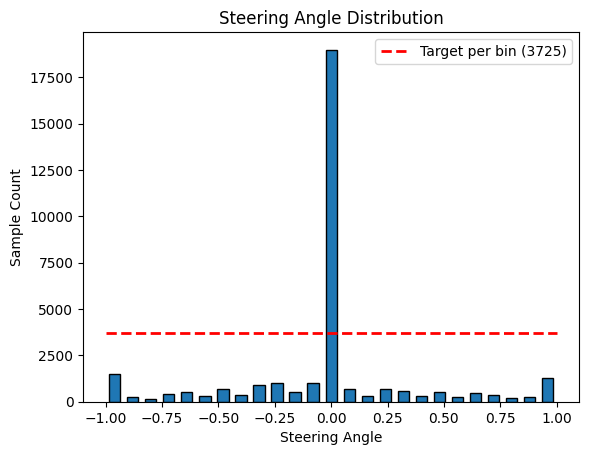

In [ ]:
import matplotlib.pyplot as plt

# Bin centers
centers = (bins[:-1] + bins[1:]) / 2

# Plot steering distribution
plt.bar(centers, hist, width=0.05, edgecolor='k')
plt.plot(
    [data["Steering"].min(), data["Steering"].max()],
    [SAMPLES_PER_BIN, SAMPLES_PER_BIN],
    "r--",
    linewidth=2,
    label=f"Target per bin ({SAMPLES_PER_BIN})"
)

plt.title("Steering Angle Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")
plt.legend()
plt.show()

In [ ]:
print(f"Total samples: {len(data)}")

Total samples: 32443


In [ ]:
remove_list = []
steering_vals = data["Steering"].values

for i in range(NUM_BINS):
    if i < NUM_BINS - 1:
        mask = (steering_vals >= bins[i]) & (steering_vals < bins[i + 1])
    else:
        mask = (steering_vals >= bins[i]) & (steering_vals <= bins[i + 1])

    indices = np.where(mask)[0]
    np.random.shuffle(indices)
    remove_list.extend(indices[SAMPLES_PER_BIN:])


In [ ]:
# Balance dataset by dropping excess samples
data_balanced = data.drop(remove_list)
print(f"Samples retained: {len(data_balanced)}")

Samples retained: 17171


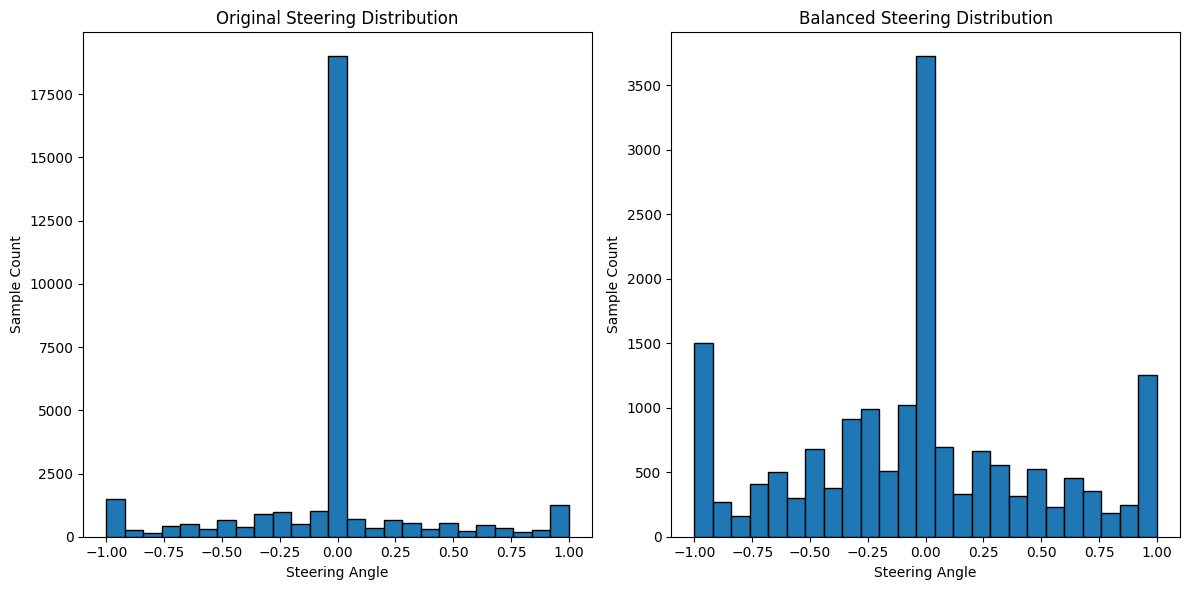

In [ ]:
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(data["Steering"], bins=NUM_BINS, edgecolor="k")
plt.title("Original Steering Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")

# Balanced distribution
plt.subplot(1, 2, 2)
plt.hist(data_balanced["Steering"], bins=NUM_BINS, edgecolor="k")
plt.title("Balanced Steering Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")

plt.tight_layout()
plt.show()

## Data splitting

---



In [ ]:
DATA_DIR = '/content/data/dataset/dataset/IMG'

In [ ]:
def load_images_and_steering(data_dir: str, df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Load image paths and steering angles with side camera corrections."""
    image_paths, steerings = [], []

    correction = 0.15
    for _, row in df.iterrows():
        center, left, right = row['Center'], row['Left'], row['Right']
        steer = float(row['Steering'])

        image_paths.extend([
            os.path.join(data_dir, center),
            os.path.join(data_dir, left),
            os.path.join(data_dir, right),
        ])
        steerings.extend([
            steer,
            steer + correction,
            steer - correction,
        ])

    return np.array(image_paths), np.array(steerings)

# Usage
image_paths, steerings = load_images_and_steering(DATA_DIR + '/', data_balanced)

In [ ]:
def fix_path(path: str) -> str:
    return path.replace("\\", "/")

for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(fix_path)

In [ ]:
# Preview data
data.sample(100)

,Center,Left,Right,Steering,Throttle,Brake,Speed
12928,center_2019_04_02_18_08_19_306.jpg,left_2019_04_02_18_08_19_306.jpg,right_2019_04_02_18_08_19_306.jpg,0.00,0.304600,0.0,7.540424
5497,center_2019_04_02_19_32_06_594.jpg,left_2019_04_02_19_32_06_594.jpg,right_2019_04_02_19_32_06_594.jpg,0.00,0.370524,0.0,10.930540
18257,center_2019_04_02_18_14_32_173.jpg,left_2019_04_02_18_14_32_173.jpg,right_2019_04_02_18_14_32_173.jpg,0.00,0.000000,0.0,9.404449
2851,center_2019_04_02_19_28_57_185.jpg,left_2019_04_02_19_28_57_185.jpg,right_2019_04_02_19_28_57_185.jpg,0.00,0.000000,0.0,12.401660
16747,center_2019_04_02_18_12_46_248.jpg,left_2019_04_02_18_12_46_248.jpg,right_2019_04_02_18_12_46_248.jpg,0.25,0.324038,0.0,10.001690
...,...,...,...,...,...,...,...
8318,center_2019_04_02_19_35_28_242.jpg,left_2019_04_02_19_35_28_242.jpg,right_2019_04_02_19_35_28_242.jpg,0.00,0.000000,0.0,13.800380
28023,center_2019_04_02_18_25_55_164.jpg,left_2019_04_02_18_25_55_164.jpg,right_2019_04_02_18_25_55_164.jpg,0.00,0.409042,0.0,12.136690
26918,center_2019_04_02_18_24_37_739.jpg,left_2019_04_02_18_24_37_739.jpg,right_2019_04_02_18_24_37_739.jpg,-0.30,0.198227,0.0,9.150699
30424,center_2019_04_02_18_28_43_233.jpg,left_2019_04_02_18_28_43_233.jpg,right_2019_04_02_18_28_43_233.jpg,-0.65,0.178874,0.0,8.040545


In [ ]:
# Split data: 80% train, 20% validation
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, steerings, test_size=0.1, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
   X_train,y_train, test_size=0.15, random_state=42
)


print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 39406
Validation samples: 6955
Test samples: 5152


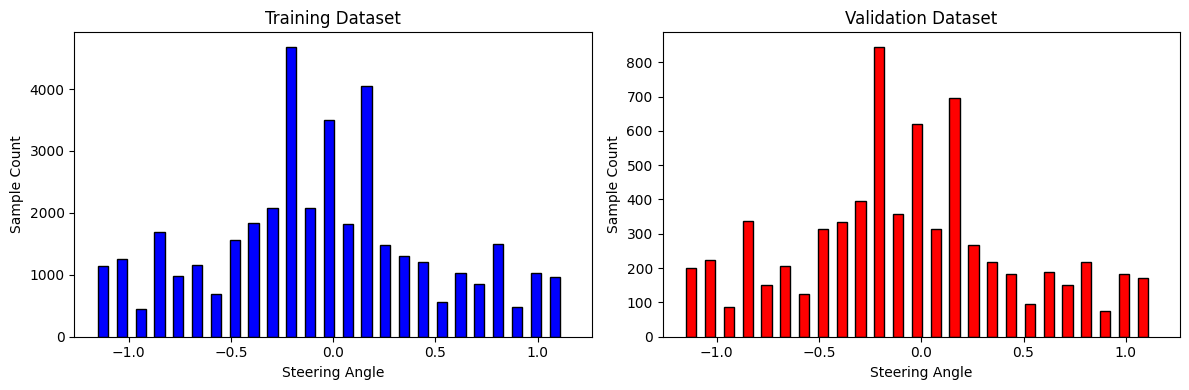

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training distribution
axes[0].hist(y_train, bins=NUM_BINS, width=0.05, color='blue', edgecolor='black')
axes[0].set(title='Training Dataset', xlabel='Steering Angle', ylabel='Sample Count')

# Validation distribution
axes[1].hist(y_val, bins=NUM_BINS, width=0.05, color='red', edgecolor='black')
axes[1].set(title='Validation Dataset', xlabel='Steering Angle', ylabel='Sample Count')

plt.tight_layout()
plt.show()

## Data augmentation

---



### Data augmentation (Nvidia)

---



In [ ]:
def normalize_nvidia(image, **kwargs):
    """Normalize image to [0,1] as in NVIDIA PilotNet."""
    return image.astype(np.float32) / 255.0

# Common transforms shared by train and val
common_transforms = [

    A.Crop(x_min=0, y_min=60, x_max=320, y_max=135, p=1.0),
 #   A.Lambda(image=lambda img, **kwargs: cv2.cvtColor(img, cv2.COLOR_RGB2YUV), p=1.0),
    A.GaussianBlur(blur_limit=3, p=1.0),
    A.Resize(height=64, width=192, interpolation=cv2.INTER_AREA, p=1.0),
    A.Lambda(image=normalize_nvidia, p=1.0),
    ToTensorV2(p=1.0),
]

def get_train_transforms():
    """NVIDIA-style augmentation pipeline for training."""
    return A.Compose([
        A.Affine(scale=(1.0, 1.4), mode=cv2.BORDER_REPLICATE, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.8, 0.2), contrast_limit=0, p=0.5),
        *common_transforms,
    ])

def get_val_transforms():

    return A.Compose(common_transforms)
def get_test_transforms():

    return A.Compose(common_transforms)



# Dataset & DataLoader

---



In [ ]:
class DrivingDataset(Dataset):
    def __init__(self, image_paths, steerings, transform=None, pan_correction=0.002):
        """
        Dataset for driving images and steering angles.

        Args:
            image_paths (list[str]): Image file paths.
            steerings (list/array): Steering angles.
            transform (callable, optional): Albumentations transform.
            pan_correction (float): Steering adjustment for horizontal pan.
        """
        self.image_paths = image_paths
        self.steerings = steerings
        self.transform = transform
        self.pan_correction = pan_correction

    def _random_flip(self, img, steering):
        if random.random() < 0.5:
            return cv2.flip(img, 1), -steering
        return img, steering

    def _random_pan(self, img, steering, pan_range_x=(-0.1, 0.1)):
        h, w = img.shape[:2]
        max_tx = int(w * pan_range_x[1])
        if max_tx == 0:
            return img, steering

        tx = random.randint(-max_tx, max_tx)
        M = np.float32([[1, 0, tx], [0, 1, 0]])
        panned_img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

        steering += (tx / max_tx) * self.pan_correction
        return panned_img, steering

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering = self.steerings[idx]

        img = np.array(Image.open(img_path).convert('RGB'))

        img, steering = self._random_flip(img, steering)
        img, steering = self._random_pan(img, steering)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, torch.tensor(steering, dtype=torch.float32)


# Vit Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import timm
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [ ]:
train_dataset = DrivingDataset(X_train, y_train, transform=get_train_transforms())
val_dataset   = DrivingDataset(X_val,   y_val, transform=get_val_transforms())
test_dataset   = DrivingDataset( X_test,   y_test, transform=get_test_transforms())

#----

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader   = DataLoader(test_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ViTRegression(nn.Module):
    def __init__(self,
                 model_name='vit_tiny_patch16_224',
                 pretrained=True,
                 drop_rate=0.3,
                 img_size=(64, 192)):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            img_size=img_size,
            dynamic_img_size=True
        )

        features = self.backbone.num_features

        self.head = nn.Sequential(
            nn.Linear(features, 256),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.head(feats)
        return out.squeeze(1)


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [ ]:
model =ViTRegression().to(device)
for param in model.backbone.parameters(): # "freeze"
    param.requires_grad = False


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import r2_score

best_val_loss = float('inf')
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss, running_mae = 0.0, 0.0
    train_preds, train_targets = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)

    for imgs, y in loop:
        imgs, y = imgs.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(imgs).squeeze()
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_mae += torch.abs(preds - y).sum().item()

        train_preds.extend(preds.detach().cpu().numpy())
        train_targets.extend(y.detach().cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_mae = running_mae / len(train_loader.dataset)

    model.eval()
    running_loss, running_mae = 0.0, 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        for imgs, y in loop_val:
            imgs, y = imgs.to(device), y.to(device)
            preds = model(imgs).squeeze()
            loss = criterion(preds, y)

            running_loss += loss.item() * imgs.size(0)
            running_mae += torch.abs(preds - y).sum().item()

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_mae = running_mae / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train: Loss={train_loss:.4f}, MAE={train_mae:.4f}| "
          f"Val: Loss={val_loss:.4f}, MAE={val_mae:.4f}")


    if epoch == 3:
        for param in model.backbone.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "vit_best_steering.pth")
        print(f"Saved best model (Loss: {val_loss:.4f})")

print("Training Done.")

Epoch 1/20 | Train: Loss=0.3006, MAE=0.4268| Val: Loss=0.2958, MAE=0.4225
Saved best model (Loss: 0.2958)


Epoch 2/20 | Train: Loss=0.2979, MAE=0.4246| Val: Loss=0.2933, MAE=0.4213
Saved best model (Loss: 0.2933)


Epoch 3/20 | Train: Loss=0.2958, MAE=0.4234| Val: Loss=0.2920, MAE=0.4202
Saved best model (Loss: 0.2920)


Epoch 4/20 | Train: Loss=0.2950, MAE=0.4224| Val: Loss=0.2901, MAE=0.4177
Saved best model (Loss: 0.2901)


Epoch 5/20 | Train: Loss=0.1414, MAE=0.2997| Val: Loss=0.1118, MAE=0.2693
Saved best model (Loss: 0.1118)


Epoch 6/20 | Train: Loss=0.1151, MAE=0.2742| Val: Loss=0.1044, MAE=0.2629
Saved best model (Loss: 0.1044)


Epoch 7/20 | Train: Loss=0.1090, MAE=0.2676| Val: Loss=0.1033, MAE=0.2605
Saved best model (Loss: 0.1033)


Epoch 8/20 | Train: Loss=0.1053, MAE=0.2632| Val: Loss=0.0977, MAE=0.2528
Saved best model (Loss: 0.0977)


Epoch 9/20 | Train: Loss=0.1015, MAE=0.2587| Val: Loss=0.0960, MAE=0.2507
Saved best model (Loss: 0.0960)


Epoch 10/20 | Train: Loss=0.0991, MAE=0.2555| Val: Loss=0.0934, MAE=0.2483
Saved best model (Loss: 0.0934)


Epoch 11/20 | Train: Loss=0.0969, MAE=0.2526| Val: Loss=0.0909, MAE=0.2446
Saved best model (Loss: 0.0909)


Epoch 12/20 | Train: Loss=0.0952, MAE=0.2499| Val: Loss=0.0898, MAE=0.2423
Saved best model (Loss: 0.0898)


Epoch 13/20 | Train: Loss=0.0934, MAE=0.2476| Val: Loss=0.0903, MAE=0.2437


Epoch 14/20 | Train: Loss=0.0920, MAE=0.2458| Val: Loss=0.0870, MAE=0.2376
Saved best model (Loss: 0.0870)


Epoch 15/20 | Train: Loss=0.0901, MAE=0.2427| Val: Loss=0.0876, MAE=0.2393


Epoch 16/20 | Train: Loss=0.0889, MAE=0.2413| Val: Loss=0.0855, MAE=0.2364
Saved best model (Loss: 0.0855)


Epoch 17/20 | Train: Loss=0.0882, MAE=0.2406| Val: Loss=0.0866, MAE=0.2371


Epoch 18/20 | Train: Loss=0.0878, MAE=0.2393| Val: Loss=0.0861, MAE=0.2376


Epoch 19/20 | Train: Loss=0.0862, MAE=0.2371| Val: Loss=0.0834, MAE=0.2325
Saved best model (Loss: 0.0834)


Epoch 20/20 | Train: Loss=0.0854, MAE=0.2361| Val: Loss=0.0849, MAE=0.2352
Training Done.


In [ ]:
try:
    model.load_state_dict(torch.load("vit_best_steering.pth"))
    print("✅ Loaded best model weights successfully.")
except FileNotFoundError:
    print("⚠️ Error: vit_best_steering.pth not found. Ensure training completed and saved the file.")
    exit()

model.eval()
test_loss = 0.0
test_mae = 0.0
total_samples = 0

print("\n▶️ Starting Test Set Evaluation...")
with torch.no_grad():
    loop_test = tqdm(test_loader, desc="[Testing]", leave=True)
    for imgs, y in loop_test:
        imgs, y = imgs.to(device), y.to(device)

        preds = model(imgs).squeeze()
        loss = criterion(preds, y)

        test_loss += loss.item() * imgs.size(0)
        test_mae += torch.abs(preds - y).sum().item()
        total_samples += imgs.size(0)

final_test_loss = test_loss / total_samples
final_test_mae = test_mae / total_samples

print("=" * 50)
print("🏁 Final Test Results")
print(f"| Test Samples: {total_samples}")
print(f"| Final Test MSE Loss: {final_test_loss:.4f}")
print(f"| Final Test MAE: {final_test_mae:.4f}")
print("=" * 50)

✅ Loaded best model weights successfully.

▶️ Starting Test Set Evaluation...


[Testing]: 100%|██████████| 161/161 [00:14<00:00, 11.23it/s]

🏁 Final Test Results
| Test Samples: 5152
| Final Test MSE Loss: 0.0860
| Final Test MAE: 0.2347
